This notebook will demonstrate how to take a trained TensorFlow model and save it as a TFLite model. The TFLite model is then something that can be deployed as part of a web application. (It'll also show you how you can used the tensorflow_datasets library, if you haven't seen that yet). 

This follows very closely the original Tensorflow Rock-Paper-Scissors TFHub + TFLite tutorial

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Rock, Paper & Scissors with TensorFlow Hub - TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c06_exercise_rock_paper_scissors_solution.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c06_exercise_rock_paper_scissors_solution.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Setup

In [2]:
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## Select the Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [3]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the rock, paper and scissors dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"rock_paper_scissors"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [5]:
splits, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True, split = ['train[:80%]','train[80%:90%]','train[90%:]'])


(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteE5YRLK/rock_paper_scissors-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteE5YRLK/rock_paper_scissors-test.tfrecord
Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [6]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label


Now shuffle and batch the data


In [7]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [8]:
train_batches = train_examples.shuffle(num_examples // 4).batch(BATCH_SIZE).map(format_image).prefetch(1)
validation_batches = validation_examples.batch(BATCH_SIZE).map(format_image).prefetch(1)
test_batches = test_examples.batch(1).map(format_image)

Inspect a batch

In [9]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [10]:
do_fine_tuning = True #@param {type:"boolean"}

In [11]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE,
                   input_shape=IMAGE_SIZE + (3, ), 
                   output_shape=[FV_SIZE],
                   trainable=do_fine_tuning),
    tf.keras.layers.Dense(num_classes)
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


## Training the model

In [12]:
if do_fine_tuning:
  model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
else:
  model.compile(
    optimizer='adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
EPOCHS = 5
hist = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
63/63 [==============================] - 27s 398ms/step - loss: 0.1958 - accuracy: 0.9613 - val_loss: 0.4818 - val_accuracy: 0.8413
Epoch 2/5
63/63 [==============================] - 25s 378ms/step - loss: 0.0857 - accuracy: 1.0000 - val_loss: 0.2614 - val_accuracy: 0.9365
Epoch 3/5
63/63 [==============================] - 25s 378ms/step - loss: 0.0845 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 0.9921
Epoch 4/5
63/63 [==============================] - 25s 378ms/step - loss: 0.0842 - accuracy: 1.0000 - val_loss: 0.0859 - val_accuracy: 1.0000
Epoch 5/5
63/63 [==============================] - 26s 386ms/step - loss: 0.0840 - accuracy: 1.0000 - val_loss: 0.0837 - val_accuracy: 1.0000


## Export the model

In [16]:
RPS_SAVED_MODEL = "rps_saved_model"

...If in Colab...

In [17]:
#Connect to google drive and save model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# CHANGE THIS TO WHEREVER YOU WANT TO SAVE THE MODEL
model_save_path = '/content/drive/MyDrive/FourthBrain/Week 11/'
full_model_save_path = model_save_path + RPS_SAVED_MODEL

Export the SavedModel

In [19]:
tf.saved_model.save(model, full_model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FourthBrain/Week 11/rps_saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FourthBrain/Week 11/rps_saved_model/assets


In [20]:
%%bash -s $full_model_save_path
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 990, in main
    args.func(args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 702, in show
    _show_inputs_outputs(args.dir, args.tag_set, args.signature_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 137, in _show_inputs_outputs
    tag_set)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 113, in get_meta_graph_def
    saved_model = read_saved_model(saved_model_dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 55, in read_saved_model
    raise IOError("SavedModel file does not exist at: %s" % saved_model_dir)
IOError: SavedModel file does no

In [21]:
loaded = tf.saved_model.load(full_model_save_path)

In [22]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


## Convert with TFLiteConverter

In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model(full_model_save_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]


tflite_model = converter.convert()
with open(model_save_path + "converted_model.tflite", "wb") as f:
  f.write(tflite_model)

Test the TFLite model using the Python Interpreter

In [24]:
# Load TFLite model and allocate tensors.
tflite_model_file = model_save_path + 'converted_model.tflite'
with open(tflite_model_file, 'rb') as fid:
  tflite_model = fid.read()
  
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [25]:
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


In [26]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  print(type(predicted_label), type(true_label))
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


<class 'numpy.int64'> <class 'numpy.int64'>


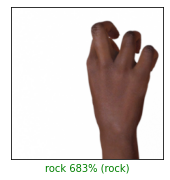

In [27]:
#@title Visualize the outputs { run: "auto" }
index = 9 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()